In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
print(torchvision.__version__)
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
print(torch.version.cuda)
torch.cuda.is_available()
import sys
print(sys.executable)
import torch
print(torch.__file__) 
print(torch.cuda.is_available())
from torch.utils import collect_env
print(collect_env.main())
from torchinfo import summary

0.14.1
11.7
c:\Anaconda\envs\pytorchenv\python.exe
c:\Anaconda\envs\pytorchenv\lib\site-packages\torch\__init__.py
True
PyTorch version: 1.13.1
Is debug build: False
CUDA used to build PyTorch: 11.7
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 11 Home
GCC version: (Rev4, Built by MSYS2 project) 12.2.0
Clang version: Could not collect
CMake version: Could not collect
Libc version: N/A

Python version: 3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.22621-SP0
Is CUDA available: True
CUDA runtime version: 11.7.99
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Nvidia driver version: 517.48
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

Versions of relevant libraries:
[pip3] numpy==1.23.5
[pip3] torch==1.13.1
[pip3] torchaudio==0.13.1
[pip3] torchinfo==1.7.1
[pip3] torchvision==0.14.1
[con

# Dataset: FashionMNIST

Training set: 60,000  
Test set: 10,000  
Each example: 28x28 grayscale image associated with 1 label from 10 classes.

See data/shape. 

Note: Pytorch stores tensors in different orientation. Therefore, we convert a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In [30]:
training_data = datasets.FashionMNIST(
    root='data/', train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data/', train=False, download=True, transform=ToTensor()
)

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_data = datasets.FashionMNIST(
    root='data/', train=True, download=True, transform=transform
)
test_data = datasets.FashionMNIST(
    root='data/', train=False, download=True, transform=transform
)

# DataLoader

In [32]:
batch_size = 64
training_dataloader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

for X, y in training_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Model

### v1

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_v1(nn.Module):
    x_size = 0
    # define the layers
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Flatten()
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=576, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.feature_extraction(x)
        x_size = x.size()
        # print(x_size)
        logits = self.dense_layers(x)
        return logits
        
model_v1 = NeuralNetwork_v1().to(device)
summary(model_v1, input_size=(batch_size, 1, 28, 28))

Using cuda device


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1                         [64, 10]                  --
├─Sequential: 1-1                        [64, 576]                 --
│    └─Conv2d: 2-1                       [64, 1, 26, 26]           10
│    └─ReLU: 2-2                         [64, 1, 26, 26]           --
│    └─Conv2d: 2-3                       [64, 1, 24, 24]           10
│    └─ReLU: 2-4                         [64, 1, 24, 24]           --
│    └─Flatten: 2-5                      [64, 576]                 --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-6                       [64, 64]                  36,928
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 32]                  2,080
│    └─ReLU: 2-9                         [64, 32]                  --
│    └─Linear: 2-10                      [64, 10]                  330
│    └─

### v1_2

In [34]:
class NeuralNetwork_v1_2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten()
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        logits = self.dense_layers(x)
        return logits

model_v1_2 = NeuralNetwork_v1_2().to(device)
summary(model_v1_2, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_2                       [64, 10]                  --
├─Sequential: 1-1                        [64, 784]                 --
│    └─Conv2d: 2-1                       [64, 1, 28, 28]           10
│    └─ReLU: 2-2                         [64, 1, 28, 28]           --
│    └─Conv2d: 2-3                       [64, 1, 28, 28]           10
│    └─ReLU: 2-4                         [64, 1, 28, 28]           --
│    └─Flatten: 2-5                      [64, 784]                 --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-6                       [64, 64]                  50,240
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 32]                  2,080
│    └─ReLU: 2-9                         [64, 32]                  --
│    └─Linear: 2-10                      [64, 10]                  330
│    └─

### v1_3

In [35]:
class NeuralNetwork_v1_3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten()
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        logits = self.dense_layers(x)
        return logits

model_v1_3 = NeuralNetwork_v1_3().to(device)
summary(model_v1_3, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_3                       [64, 10]                  --
├─Sequential: 1-1                        [64, 784]                 --
│    └─Conv2d: 2-1                       [64, 1, 28, 28]           10
│    └─ReLU: 2-2                         [64, 1, 28, 28]           --
│    └─Conv2d: 2-3                       [64, 1, 28, 28]           10
│    └─ReLU: 2-4                         [64, 1, 28, 28]           --
│    └─Flatten: 2-5                      [64, 784]                 --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-6                       [64, 64]                  50,240
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 64]                  4,160
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 10]                  650
│    └─

### v1_4

In [36]:
class NeuralNetwork_v1_4(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.feature_extraction(x)
        # print()
        # logits = self.dense_layers(x)
        return x

model_v1_4 = NeuralNetwork_v1_4().to(device)
summary(model_v1_4, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_4                       [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Flatten: 2-5                      [64, 50176]               --
│    └─Linear: 2-6                       [64, 64]                  3,211,328
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 64]                  4,160
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 10]                  650
│    └─Softmax: 2-11                     [64, 10]                  --

### v1_4_1

In [37]:
class NeuralNetwork_v1_4_1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.feature_extraction(x)
        return x

model_v1_4_1 = NeuralNetwork_v1_4_1().to(device)
summary(model_v1_4_1, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_4_1                     [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Flatten: 2-5                      [64, 50176]               --
│    └─Linear: 2-6                       [64, 64]                  3,211,328
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 64]                  4,160
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 64]                  4,160
│    └─ReLU: 2-11                        [64, 64]                  

### v1_5

In [38]:
class NeuralNetwork_v1_5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5 = NeuralNetwork_v1_5().to(device)
summary(model_v1_5, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5                       [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 128, 28, 28]         73,856
│    └─ReLU: 2-6                         [64, 128, 28, 28]         --
│    └─Flatten: 2-7                      [64, 100352]              --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-8                       [64, 64]                  6,422,592
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 64]                  4,

### v1_5_1

In [39]:
class NeuralNetwork_v1_5_1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten()
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_1 = NeuralNetwork_v1_5_1().to(device)
summary(model_v1_5_1, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_1                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 128, 28, 28]         73,856
│    └─ReLU: 2-6                         [64, 128, 28, 28]         --
│    └─Flatten: 2-7                      [64, 100352]              --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-8                       [64, 64]                  6,422,592
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 64]                  4,

### v1_5_2

In [40]:
class NeuralNetwork_v1_5_2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_2 = NeuralNetwork_v1_5_2().to(device)
summary(model_v1_5_2, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_2                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 128, 28, 28]         73,856
│    └─ReLU: 2-6                         [64, 128, 28, 28]         --
│    └─Flatten: 2-7                      [64, 100352]              --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-8                       [64, 64]                  6,422,592
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 64]                  4,

### v1_5_2b

In [41]:
class NeuralNetwork_v1_5_2b(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_2b = NeuralNetwork_v1_5_2b().to(device)
summary(model_v1_5_2b, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_2b                    [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 128, 28, 28]         73,856
│    └─ReLU: 2-6                         [64, 128, 28, 28]         --
│    └─Flatten: 2-7                      [64, 100352]              --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-8                       [64, 128]                 12,845,184
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Linear: 2-10                      [64, 64]                  8

### v1_5_3

In [42]:
class NeuralNetwork_v1_5_3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_3 = NeuralNetwork_v1_5_3().to(device)
summary(model_v1_5_3, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_3                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─ReLU: 2-3                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-4                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-5                       [64, 64, 28, 28]          36,928
│    └─ReLU: 2-6                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-7                       [64, 128, 28, 28]         73,856
│    └─Conv2d: 2-8                       [64, 128, 28, 28]         147,584
│    └─ReLU: 2-9                         [64, 128, 28, 28]         --
│    └─Flatten: 2-10                     [64, 100352]              --
├─Sequential: 1-2                        [64, 10]               

### v1_5_4

In [43]:
# Increasing num of elt in dense layer
class NeuralNetwork_v1_5_4(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_4 = NeuralNetwork_v1_5_4().to(device)
summary(model_v1_5_4, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_4                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─ReLU: 2-3                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-4                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-5                       [64, 64, 28, 28]          36,928
│    └─ReLU: 2-6                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-7                       [64, 128, 28, 28]         73,856
│    └─Conv2d: 2-8                       [64, 128, 28, 28]         147,584
│    └─ReLU: 2-9                         [64, 128, 28, 28]         --
│    └─Flatten: 2-10                     [64, 100352]              --
├─Sequential: 1-2                        [64, 10]               

### v1_5_5

In [44]:
# Increasing num of elt in 1st layer 128->258. Reducing 2nd dense layer 128 -> 64
class NeuralNetwork_v1_5_5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_5 = NeuralNetwork_v1_5_5().to(device)
summary(model_v1_5_5, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_5                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─ReLU: 2-3                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-4                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-5                       [64, 64, 28, 28]          36,928
│    └─ReLU: 2-6                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-7                       [64, 128, 28, 28]         73,856
│    └─Conv2d: 2-8                       [64, 128, 28, 28]         147,584
│    └─ReLU: 2-9                         [64, 128, 28, 28]         --
│    └─Flatten: 2-10                     [64, 100352]              --
├─Sequential: 1-2                        [64, 10]               

### v1_5_5_BN

In [45]:
# Adding BN before every activation layer.
class NeuralNetwork_v1_5_5_BN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_5_BN = NeuralNetwork_v1_5_5_BN().to(device)
summary(model_v1_5_5_BN, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_5_BN                  [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─BatchNorm2d: 2-3                  [64, 32, 28, 28]          64
│    └─ReLU: 2-4                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-6                       [64, 64, 28, 28]          36,928
│    └─BatchNorm2d: 2-7                  [64, 64, 28, 28]          128
│    └─ReLU: 2-8                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-9                       [64, 128, 28, 28]         73,856
│    └─Conv2d: 2-10                      [64, 128, 28, 28]         147,584
│    └─BatchNorm2d: 2-11                 [64, 128, 28, 28]     

### v1_5_6

In [46]:
# Adding dropout after activations.
class NeuralNetwork_v1_5_6(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*128, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_5_6 = NeuralNetwork_v1_5_6().to(device)
summary(model_v1_5_6, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_5_6                     [64, 10]                  --
├─Sequential: 1-1                        [64, 100352]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─BatchNorm2d: 2-3                  [64, 32, 28, 28]          64
│    └─ReLU: 2-4                         [64, 32, 28, 28]          --
│    └─Dropout: 2-5                      [64, 32, 28, 28]          --
│    └─Conv2d: 2-6                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-7                       [64, 64, 28, 28]          36,928
│    └─BatchNorm2d: 2-8                  [64, 64, 28, 28]          128
│    └─ReLU: 2-9                         [64, 64, 28, 28]          --
│    └─Dropout: 2-10                     [64, 64, 28, 28]          --
│    └─Conv2d: 2-11                      [64, 128, 28, 28]         73,85

### v1_6

In [47]:
# Adding dropout after activations.
class NeuralNetwork_v1_6(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding='same'),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=28*28*512, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.feature_extraction(x)
        logits = self.dense_layers(logits)
        return logits

model_v1_6 = NeuralNetwork_v1_6().to(device)
summary(model_v1_6, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork_v1_6                       [64, 10]                  --
├─Sequential: 1-1                        [64, 401408]              --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [64, 32, 28, 28]          9,248
│    └─BatchNorm2d: 2-3                  [64, 32, 28, 28]          64
│    └─ReLU: 2-4                         [64, 32, 28, 28]          --
│    └─Conv2d: 2-5                       [64, 64, 28, 28]          18,496
│    └─Conv2d: 2-6                       [64, 64, 28, 28]          36,928
│    └─BatchNorm2d: 2-7                  [64, 64, 28, 28]          128
│    └─ReLU: 2-8                         [64, 64, 28, 28]          --
│    └─Conv2d: 2-9                       [64, 128, 28, 28]         73,856
│    └─Conv2d: 2-10                      [64, 128, 28, 28]         147,584
│    └─BatchNorm2d: 2-11                 [64, 128, 28, 28]     

### Pretrained resnet18

In [20]:
from torchvision import datasets, models, transforms

resnet18 = models.resnet18(weights='DEFAULT')
num_ftrs = resnet18.fc.in_features
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18.to(device)
summary(resnet18, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 14, 14]          3,136
├─BatchNorm2d: 1-2                       [64, 64, 14, 14]          128
├─ReLU: 1-3                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Sequential: 1-5                        [64, 64, 7, 7]            --
│    └─BasicBlock: 2-1                   [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-1                  [64, 64, 7, 7]            36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 7, 7]            128
│    │    └─ReLU: 3-3                    [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-4                  [64, 64, 7, 7]            36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 7, 7]            128
│    │    └─ReLU: 3-6                    [64, 64, 7, 7]            --
│

# Training fn

In [21]:
history_dict = {'train loss':[], 'train accuracy':[], 'val loss':[], 'val accuracy':[]}

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # Num of samples.
    num_batches = len(dataloader) # Num of batches.
    model.train() # set model to training mode.
    epoch_loss, correct = 0, 0 # avg loss of the current epoch.
    for batch, (X, y) in enumerate(dataloader): # FP and BP each batch of data.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) # 
        loss = loss_fn(pred, y) #
        # Backpropagation
        optimizer.zero_grad() # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward() #
        optimizer.step() #

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        
    epoch_loss /= num_batches
    correct /= size
    history_dict['train loss'].append(epoch_loss)
    history_dict['train accuracy'].append(100*correct)
        
        # save los

# Testing fn

In [23]:
test_loss = 0.0
best_acc = 0.0
curr_acc = 0.0
def test(dataloader, model, loss_fn):
    '''
    Returns test accuracy.
    '''
    global test_loss
    global best_acc
    global curr_acc

    size = len(dataloader.dataset) # Num of samples in the dataset.
    num_batches = len(dataloader) # Num of batches.
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader: # X, y contain all the samples in the current batch.
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    curr_acc = 100*correct
    history_dict['val loss'].append(test_loss)
    history_dict['val accuracy'].append(100*correct)

# Plotting Function

In [24]:
import matplotlib.pyplot as plt 
import os

def plot_Acc_And_Loss(model_name, history_dict, save=True):
    """
    Plots loss and accuracy of train and val data over epochs.
    :return:
    """
    plt.plot(history_dict['train accuracy'])
    plt.plot(history_dict['val accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save: 
        if not os.path.exists(f'model_logs/{model_name}_logs/'):
            os.makedirs(f'model_logs/{model_name}_logs/')
        plt.savefig(f'model_logs/{model_name}_logs/{model_name}_accuracy.png')
    plt.show()

    plt.plot(history_dict['train loss'])
    plt.plot(history_dict['val loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save: 
        if not os.path.exists(f'model_logs/{model_name}_logs/'):
            os.makedirs(f'model_logs/{model_name}_logs/')
        plt.savefig(f'model_logs/{model_name}_logs/{model_name}_loss.png')
    plt.show()

# Loss and Optimizer
Choco  
Learning rate

In [25]:
# MODEL_NAME = 't0'
# save = True
# model = NeuralNetwork_v1_6().to(device)
# loss_fn = nn.CrossEntropyLoss()
# # lr = 100*1e-3
# # optimizer = torch.optim.SGD(model.parameters(), lr=lr) # Stochastic gradient descent
# # scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=2)
# lr = 1e-3
# optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer=optimizer)

In [26]:
def train_test_loop(model_name, save, epochs, model, loss_fn, optimizer, scheduler):
    global test_loss
    global best_acc
    global curr_acc
    epoch = 1
    print("Training\n")
    for i in range(epochs):
        print(f"Epoch {i}\n-------------------------------")
        train(dataloader=training_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer)
        test(dataloader=test_dataloader, model=model, loss_fn=loss_fn)

        if curr_acc > best_acc:
            best_acc = curr_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                'acc': best_acc
            }, f"models/{model_name}")
            print(f"Saved model at Epoch: {epoch}, Test Acc: {best_acc}, to models/{model_name} \n")
        
        scheduler.step(test_loss)
        epoch+=1
    print("Training done!\n")

    %matplotlib inline
    plot_Acc_And_Loss(model_name, history_dict, save)
    print("Plots saved.\n")

    # model.load_state_dict(torch.load(f"models/{MODEL_NAME}"))
    checkpoint = torch.load(f"models/{model_name}")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
    ]

    model.eval()
    for sample in range(0, 10):
        x, y = test_data[sample][0], test_data[sample][1] # get 1st sample and corresponding label.
        with torch.no_grad():
            x = torch.unsqueeze(x, 0)
            pred = model(x.to(device))
            predicted, actual = classes[pred[0].argmax(0)], classes[y]
            print(f'Predicted: "{predicted}", Actual: "{actual}"')

Training

Epoch 0
-------------------------------


c:\Anaconda\envs\pytorchenv\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 2.303935  [    0/60000]
loss: 2.303555  [ 6400/60000]
loss: 2.303809  [12800/60000]
loss: 2.302708  [19200/60000]
loss: 2.303348  [25600/60000]
loss: 2.302932  [32000/60000]
loss: 2.302087  [38400/60000]
loss: 2.302583  [44800/60000]
loss: 2.302677  [51200/60000]
loss: 2.301754  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302656
Saved model at Epoch: 1, Test Acc: 10.0, to models/model_v1 

Epoch 1
-------------------------------
loss: 2.305325  [    0/60000]


c:\Anaconda\envs\pytorchenv\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss: 2.303368  [ 6400/60000]
loss: 2.302685  [12800/60000]
loss: 2.301113  [19200/60000]
loss: 2.301823  [25600/60000]
loss: 2.302423  [32000/60000]
loss: 2.302868  [38400/60000]
loss: 2.303358  [44800/60000]
loss: 2.302201  [51200/60000]
loss: 2.301037  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302627
Epoch 2
-------------------------------
loss: 2.303013  [    0/60000]
loss: 2.301439  [ 6400/60000]
loss: 2.301647  [12800/60000]
loss: 2.301176  [19200/60000]
loss: 2.302931  [25600/60000]
loss: 2.304185  [32000/60000]
loss: 2.298985  [38400/60000]
loss: 2.303960  [44800/60000]
loss: 2.303170  [51200/60000]
loss: 2.302958  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302647
Epoch 3
-------------------------------
loss: 2.304871  [    0/60000]
loss: 2.303468  [ 6400/60000]
loss: 2.302635  [12800/60000]
loss: 2.302093  [19200/60000]
loss: 2.303209  [25600/60000]
loss: 2.303307  [32000/60000]
loss: 2.303186  [38400/60000]
loss: 2.302901  [44800/60000]
loss: 2.30

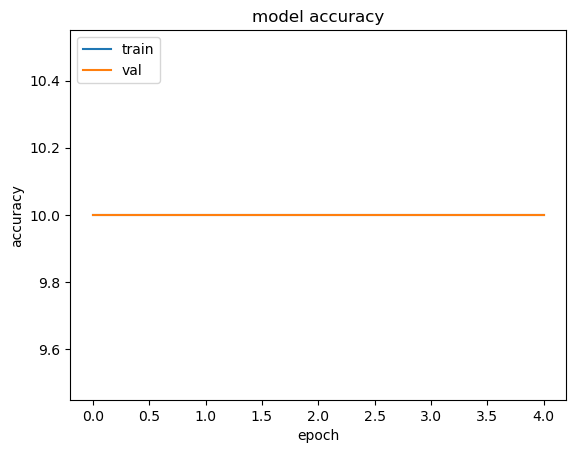

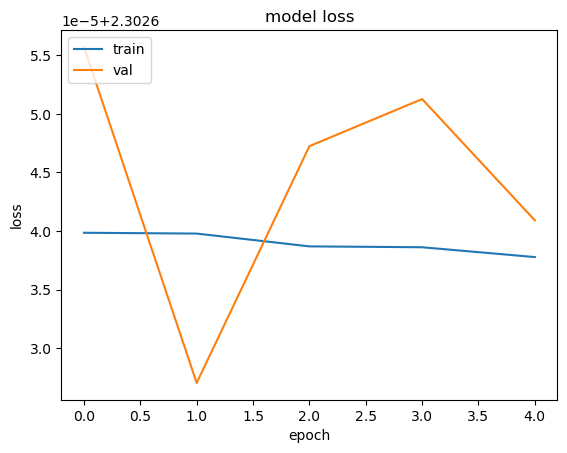

Plots saved.

Predicted: "Trouser", Actual: "Ankle boot"
Predicted: "Trouser", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Coat"
Predicted: "Trouser", Actual: "Shirt"
Predicted: "Trouser", Actual: "Sandal"
Predicted: "Trouser", Actual: "Sneaker"


In [27]:
lr = 1e-3
# optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
optimizer = torch.optim.SGD(resnet18.parameters(), lr=lr, momentum=0.9) # Stochastic gradient descent
# scheduler = ReduceLROnPlateau(optimizer=optimizer)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

train_test_loop(
    model_name='model_v1',
    save=True,
    epochs=5,
    model=model_v1,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler
)